In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

'''
y[n] = exp(-i 2*pi*n*k/N) + w[n]
w[n] = a[n] + ib[n]
SNR = (1/(s^2))
SNRdB = 10*log10(SNR). 
'''


'\ny[n] = exp(-i 2*pi*n*k/N) + w[n]\nw[n] = a[n] + ib[n]\nSNR = (1/(s^2))\nSNRdB = 10*log10(SNR). \n'

In [3]:
def pure_signal(N, k):
    return [np.exp(-1j * 2 * np.pi * k * n / N) for n in range(N)]

def noisy_signal(N, k, SNRdB):
    signal = pure_signal(N, k)
    s = np.sqrt(1 / (10 ** (SNRdB / 10)))
    a = np.random.randn(N) * s / np.sqrt(2)
    b = np.random.randn(N)* s / np.sqrt(2)
    noise = a + 1j*b
    return signal + noise

# returns tuple of m samples of noisy signals and chosen sampling indices
def subsampled_noisy(N, k, SNRdB, m):
    noisy_sig = noisy_signal(N, k, SNRdB)
    chosen_indices = np.sort(np.random.choice(range(N), size=m, replace=False))
    return (np.take(noisy_sig, chosen_indices), chosen_indices)

def imag_to_pair(signal):
    ret = []
    for i in signal:
        ret.append(np.round(np.real(i), 3))
        ret.append(np.round(np.imag(i), 3))
    return ret

def one_hot(N, batch_size, freqs):
    freqs_one_hot = np.zeros((batch_size, N))
    freqs_one_hot[np.arange(batch_size), freqs] = 1
    return freqs_one_hot

def batch_pure(N, batch_size):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = pure_signal(N, freq)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
    return signals, one_hot(N, batch_size, freqs)

def batch_noisy(N, SNRdB, batch_size):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = noisy_signal(N, freq, SNRdB)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
    return signals, one_hot(N, batch_size, freqs)
        
def batch_noisy_subsampled(N, SNRdB, m, batch_size):
    signals, freqs, indices = [], [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal, index = subsampled_noisy(N, freq, SNRdB, m)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
        indices.append(index)
    return signals, one_hot(N, batch_size, freqs), indices

def batch_noisy_subsampled(N, SNRdB, m, batch_size, indices):
    signals, freqs, repeated_ind = [], [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = noisy_signal(N, freq, SNRdB)
        sub_signal = np.take(signal, indices)
        signals.append(imag_to_pair(sub_signal))
        freqs.append(freq)
        repeated_ind.append(indices)
    return signals, one_hot(N, batch_size, freqs), repeated_ind

def batch_noisy_subsampled_raw(N, SNRdB, m, batch_size, indices):
    signals, freqs, repeated_ind = [], [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = noisy_signal(N, freq, SNRdB)
        sub_signal = np.take(signal, indices)
        signals.append(imag_to_pair(sub_signal))
        freqs.append([freq])
        repeated_ind.append(indices)
    return signals, freqs, repeated_ind

def test_noisy_mle(N, signals, freqs):
    count = 0
    imag_signals = []    
    for index in range(len(signals)):
        sig = signals[index]
        imag_sig = [(sig[i] + 1j*sig[i+1]) for i in np.arange(len(sig), step=2)]
        imag_signals.append(imag_sig)
                     
    for index in range(len(signals)):
        cleans = [pure_signal(N, i) for i in range(N)]
        dots = [np.absolute(np.vdot(imag_signals[index], cleans[i])) for i in range(N)]
        if np.argmax(freqs[index]) == np.argmax(dots):
            count += 1
    return count / len(freqs)

def test_noisy_subsampled_mle(N, signals, freqs, indices):
    count = 0
    imag_signals = []    
    for index in range(len(signals)):
        sig = signals[index]
        imag_sig = [(sig[i] + 1j*sig[i+1]) for i in np.arange(len(sig), step=2)]
        imag_signals.append(imag_sig)
                     
    for index in range(len(signals)):
        cleans = [np.take(pure_signal(N, i), indices[index]) for i in range(N)]
        dots = [np.absolute(np.vdot(imag_signals[index], cleans[i])) for i in range(N)]
        if np.argmax(freqs[index]) == np.argmax(dots):
            count += 1
    return count / len(freqs)

In [4]:
def make_signal(w,theta,n):
    """
    Assumes normalized amplitude
    """
    t = np.arange(n)
    signal = np.exp(1j*(w*t + theta))
    return signal

def make_noise(sigma2,n):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
    return noise

def make_noisy_signal(w,theta,SNRdb,n):
    sigma2 = get_sigma2_from_snrdb(SNRdb)
    signal = make_signal(w,theta,n)
    noise  = make_noise(sigma2,n)
    return signal + noise

# N = divisor of w0
# m = num samples
def make_batch_noisy(batch_size, SNRdb, N, m):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        w = (2 * np.pi * freq / N) % (2 * np.pi)
        sig = make_noisy_signal(w, 0, SNRdb, m)
        signals.append(sig)
        freqs.append(freq)
    return signals, one_hot(N, batch_size, freqs)

def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def kay_weights(N):
    scaling = (3.0/2)*N/(N**2 - 1)
    
    w = [1 - ((i - (N/2 - 1))/(N/2))**2 for i in range(N-1)]
    
    return scaling*np.array(w)

def kays_method(my_signal):
    N = len(my_signal)
    w = kay_weights(N)
    
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
    need_to_shift = np.any(angle_diff < -np.pi/2)
    if need_to_shift:    
        neg_idx = angle_diff < 0
        angle_diff[neg_idx] += np.pi*2
    
    return w.dot(angle_diff)

def test_kays(signals, freqs, N):
    count = 0
    for sig, freq in zip(signals, freqs):
        res = kays_method(sig)
        res = round(res * N / (2 * np.pi))
        if np.argmax(freq) == res:
            count += 1
    return count / len(signals)

def test_mle(signals, freqs, N, m):
    count = 0
    for sig, freq in zip(signals, freqs):
        cleans = [make_signal(np.pi * 2 * w / N, 0, m) for w in range(N)]
        dots = [np.absolute(np.vdot(sig, clean)) for clean in cleans]
        if np.argmax(dots) == np.argmax(freq):
            count += 1
    return count / len(signals)
    
    

In [171]:
'''snrs = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
N = 512
m = 32
accs_kay, accs_mle = [], []
for snr in snrs:
    sig, freq = make_batch_noisy(1000, snr, N, m)
    accs_kay.append(test_kays(sig, freq, N))
    accs_mle.append(test_mle(sig, freq, N, m))
accs2_kay, accs2_mle = [], []
snr = 10
ms = [128, 96, 64, 48, 32, 24, 16, 8]
for currm in ms:
    sig, freq = make_batch_noisy(1000, snr, N, currm)
    accs2_kay.append(test_kays(sig, freq, N))
    accs2_mle.append(test_mle(sig, freq, N, currm))'''

'snrs = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]\nN = 512\nm = 32\naccs_kay, accs_mle = [], []\nfor snr in snrs:\n    sig, freq = make_batch_noisy(1000, snr, N, m)\n    accs_kay.append(test_kays(sig, freq, N))\n    accs_mle.append(test_mle(sig, freq, N, m))\naccs2_kay, accs2_mle = [], []\nsnr = 10\nms = [128, 96, 64, 48, 32, 24, 16, 8]\nfor currm in ms:\n    sig, freq = make_batch_noisy(1000, snr, N, currm)\n    accs2_kay.append(test_kays(sig, freq, N))\n    accs2_mle.append(test_mle(sig, freq, N, currm))'

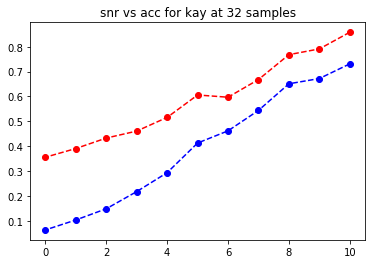

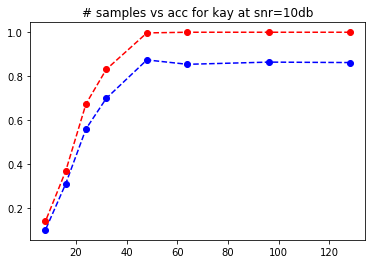

In [170]:
plt.plot(np.load('./data/snr/snrs.npy'), np.load('./data/snr/kay.npy'), '--bo')
plt.plot(np.load('./data/snr/snrs.npy'), np.load('./data/snr/mle.npy'), '--ro')
plt.title('snr vs acc for kay at 32 samples')
plt.show()
plt.plot(np.load('./data/m/ms.npy'), np.load('./data/m/kay.npy'), '--bo')
plt.plot(np.load('./data/m/ms.npy'), np.load('./data/m/mle.npy'), '--ro')
plt.title('# samples vs acc for kay at snr=10db')
plt.show()
# 1000 samples foreach trial

In [17]:
'''snr = -10
N = 512
m = 50
num_trials = 1000
count = 0
for ind in range(num_trials):
    k = np.random.randint(0, N)
    noisy, indices = subsampled_noisy(N, k, snr, m)
    cleans = [np.take(pure_signal(N, i), indices) for i in range(N)]
    dots = [np.absolute(np.vdot(cleans[i], noisy)) for i in range(N)] 
    if k == np.argmax(dots):
        count += 1
print(count / num_trials)
'''

with tf.Session() as sess:
    a = [[-1.0, 1, 2], [0, -1, 3], [1,  -1, 10], [2, 2, 3]]
    b = tf.tanh(a).eval()
    print(b)
a = [1, 2, 3]
np.save('./data/a', a)

[[-0.76159418  0.76159418  0.96402758]
 [ 0.         -0.76159418  0.99505472]
 [ 0.76159418 -0.76159418  1.        ]
 [ 0.96402758  0.96402758  0.99505472]]


In [146]:
#cnn one hot

nn_accs = []
mle_accs = []

snrs = [0]




for SNRdB in snrs:

    N = 32
    SNRdB = 10
    m = 32

    # Parameters
    learning_rate = 0.0001
    num_iter = 100000
    batch_size = 64

    # Network Parameters
    num_classes = N

    # tf Graph input
    X = tf.placeholder("float", [None, m, 2])
    Y = tf.placeholder("float", [None, num_classes])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([2, 2, 8])), # filtersize, in channels, outchannels
        'out': tf.Variable(tf.random_normal([27*8, num_classes])),
        'h2': tf.Variable(tf.random_normal([3, 8, 8])),
        'h3': tf.Variable(tf.random_normal([3, 8, 8]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([8])),
        'out': tf.Variable(tf.random_normal([num_classes])),
        'b2': tf.Variable(tf.random_normal([8])),
        'b3': tf.Variable(tf.random_normal([8]))
    }

    indices = np.sort(np.random.choice(range(N), size=m, replace=False))

    test_signals, test_freqs = make_batch_noisy(batch_size, SNRdB, N, m)
    test_signals_pair = np.zeros((batch_size, m, 2))
    test_signals_pair[:, :, 0] = np.real(test_signals)
    test_signals_pair[:, :, 1] = np.imag(test_signals)
    
    
    dict = {}
    for i in range(10):
        batch_x, batch_y = make_batch_noisy(batch_size, SNRdB, N, m)
        batch_x_pair = np.zeros((batch_size, m, 2))
        batch_x_pair[:, :, 0] = np.real(test_signals)
        batch_x_pair[:, :, 1] = np.imag(test_signals)
        dict[i] = (batch_x_pair, batch_y)

    def neural_net(x):
        layer_1 = tf.add(tf.nn.conv1d(x, weights['h1'], 1, 'VALID'), biases['b1'])
        hidden_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.nn.conv1d(hidden_1, weights['h2'], 1, 'VALID'), biases['b2'])
        hidden_2 = tf.nn.relu(layer_2)
        layer_3 = tf.add(tf.nn.conv1d(hidden_2, weights['h3'], 1, 'VALID'), biases['b3'])
        hidden_3 = tf.nn.relu(layer_3)
        hidden_3 = tf.reshape(hidden_3, [batch_size, -1])
        out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.nn.softmax(logits)
    losses, accuracies = [], []

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y))  
    ''' + 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out'])\
    + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out'])'''
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            '''batch_x, batch_y = make_batch_noisy(batch_size, SNRdB, N, m)
            batch_x_pair = np.zeros((batch_size, m, 2))
            batch_x_pair[:, :, 0] = np.real(test_signals)
            batch_x_pair[:, :, 1] = np.imag(test_signals)'''
            batch_x_pair, batch_y = dict[step % 10]

            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
            if step % 100 == 0:
                # Calculate batch loss and accuracy
                loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                     Y: batch_y})

                print("pred: ", [np.argmax(a) for a in pred[:8]])
                print("act:", [np.argmax(a) for a in batch_y[:8]])
                accuracies.append(acc)
                losses.append(loss)
                print("snr: ", SNRdB)
                print("Iter " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

        print("Training Finished")

        nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})
        kay_acc = test_kays(test_signals, test_freqs, N)
        
        print("Testing Accuracy Neural:", nn_acc)

        print("Testing Accuracy Kay:", mle_acc)
        nn_accs.append(nn_acc)
        mle_accs.append(mle_acc)
#np.save('./data/snrs', snrs)
#np.save('./data/nn_accs2', nn_accs)
#np.save('./data/mle_accs2', mle_accs)

pred:  [14, 20, 28, 14, 14, 14, 20, 14]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 100, Minibatch Loss= 514.5278, Training Accuracy= 0.047
pred:  [14, 20, 28, 14, 14, 14, 28, 14]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 200, Minibatch Loss= 457.7607, Training Accuracy= 0.047
pred:  [14, 20, 28, 14, 14, 14, 28, 14]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 300, Minibatch Loss= 409.7876, Training Accuracy= 0.047
pred:  [14, 20, 28, 14, 14, 14, 28, 14]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 400, Minibatch Loss= 368.9312, Training Accuracy= 0.031
pred:  [14, 20, 28, 14, 14, 14, 28, 14]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 500, Minibatch Loss= 334.1262, Training Accuracy= 0.031
pred:  [14, 20, 28, 14, 14, 14, 16, 14]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 600, Minibatch Loss= 304.3940, Training Accuracy= 0.031
pred:  [14, 20, 28, 14, 14, 14, 19, 14]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 700, Minibatch Loss= 278.0239, Training Accuracy

pred:  [13, 5, 24, 3, 3, 11, 4, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 5900, Minibatch Loss= 8.1347, Training Accuracy= 0.094
pred:  [1, 5, 24, 3, 3, 11, 4, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 6000, Minibatch Loss= 7.0563, Training Accuracy= 0.094
pred:  [4, 24, 24, 3, 3, 11, 9, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 6100, Minibatch Loss= 6.1402, Training Accuracy= 0.125
pred:  [4, 24, 24, 28, 3, 11, 9, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 6200, Minibatch Loss= 5.5638, Training Accuracy= 0.125
pred:  [22, 24, 24, 28, 20, 11, 9, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 6300, Minibatch Loss= 5.2384, Training Accuracy= 0.078
pred:  [22, 24, 24, 28, 20, 11, 9, 4]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 6400, Minibatch Loss= 4.9609, Training Accuracy= 0.078
pred:  [22, 24, 24, 28, 11, 11, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 6500, Minibatch Loss= 4.7233, Training Accuracy= 0.094
pred:  [22, 27, 20, 

pred:  [22, 19, 9, 19, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 11900, Minibatch Loss= 3.6043, Training Accuracy= 0.078
pred:  [22, 19, 9, 19, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 12000, Minibatch Loss= 3.6005, Training Accuracy= 0.078
pred:  [22, 19, 9, 19, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 12100, Minibatch Loss= 3.5975, Training Accuracy= 0.078
pred:  [22, 19, 9, 19, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 12200, Minibatch Loss= 3.5941, Training Accuracy= 0.078
pred:  [22, 19, 9, 19, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 12300, Minibatch Loss= 3.5910, Training Accuracy= 0.062
pred:  [22, 19, 9, 19, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 12400, Minibatch Loss= 3.5876, Training Accuracy= 0.062
pred:  [22, 19, 9, 19, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 12500, Minibatch Loss= 3.5839, Training Accuracy= 0.062
pred:  [22, 19, 9, 19, 9, 9

pred:  [22, 18, 9, 16, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 17900, Minibatch Loss= 3.4111, Training Accuracy= 0.078
pred:  [22, 18, 9, 16, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 18000, Minibatch Loss= 3.4080, Training Accuracy= 0.094
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 18100, Minibatch Loss= 3.4059, Training Accuracy= 0.094
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 18200, Minibatch Loss= 3.4028, Training Accuracy= 0.094
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 18300, Minibatch Loss= 3.4001, Training Accuracy= 0.094
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 18400, Minibatch Loss= 3.3974, Training Accuracy= 0.094
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 18500, Minibatch Loss= 3.3949, Training Accuracy= 0.094
pred:  [22, 18, 9, 4, 9, 9, 9, 9

pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 23900, Minibatch Loss= 3.2567, Training Accuracy= 0.062
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 24000, Minibatch Loss= 3.2547, Training Accuracy= 0.062
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 24100, Minibatch Loss= 3.2526, Training Accuracy= 0.062
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 24200, Minibatch Loss= 3.2510, Training Accuracy= 0.062
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 24300, Minibatch Loss= 3.2484, Training Accuracy= 0.062
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 24400, Minibatch Loss= 3.2463, Training Accuracy= 0.062
pred:  [22, 18, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 24500, Minibatch Loss= 3.2437, Training Accuracy= 0.062
pred:  [22, 18, 9, 4, 9, 9, 9, 9]


pred:  [22, 31, 9, 4, 9, 9, 9, 9]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 29900, Minibatch Loss= 3.1565, Training Accuracy= 0.094
pred:  [22, 31, 31, 4, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 30000, Minibatch Loss= 3.1552, Training Accuracy= 0.141
pred:  [22, 31, 31, 4, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 30100, Minibatch Loss= 3.1542, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 30200, Minibatch Loss= 3.1530, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 30300, Minibatch Loss= 3.1518, Training Accuracy= 0.141
pred:  [22, 31, 31, 4, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 30400, Minibatch Loss= 3.1505, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 30500, Minibatch Loss= 3.1491, Training Accuracy= 0.141
pred

pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 35700, Minibatch Loss= 3.1000, Training Accuracy= 0.156
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 35800, Minibatch Loss= 3.0995, Training Accuracy= 0.156
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 35900, Minibatch Loss= 3.0986, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 36000, Minibatch Loss= 3.0977, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 36100, Minibatch Loss= 3.0971, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 36200, Minibatch Loss= 3.0962, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 36300, Minibatch Loss= 3.0958, Training Accuracy= 0.141

pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 41500, Minibatch Loss= 3.0565, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 41600, Minibatch Loss= 3.0556, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 31]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 41700, Minibatch Loss= 3.0547, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 41800, Minibatch Loss= 3.0552, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 41900, Minibatch Loss= 3.0542, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 42000, Minibatch Loss= 3.0534, Training Accuracy= 0.141
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 42100, Minibatch Loss= 3.0524, Training Accuracy= 0.141

pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 47300, Minibatch Loss= 3.0106, Training Accuracy= 0.156
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 47400, Minibatch Loss= 3.0101, Training Accuracy= 0.156
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 47500, Minibatch Loss= 3.0093, Training Accuracy= 0.156
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 47600, Minibatch Loss= 3.0088, Training Accuracy= 0.156
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 47700, Minibatch Loss= 3.0082, Training Accuracy= 0.156
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 47800, Minibatch Loss= 3.0073, Training Accuracy= 0.156
pred:  [22, 31, 31, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 47900, Minibatch Loss= 3.0070, Training Accuracy= 0.156

pred:  [22, 31, 6, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 53100, Minibatch Loss= 2.9734, Training Accuracy= 0.156
pred:  [22, 31, 6, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 53200, Minibatch Loss= 2.9728, Training Accuracy= 0.172
pred:  [22, 31, 6, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 53300, Minibatch Loss= 2.9723, Training Accuracy= 0.172
pred:  [22, 31, 6, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 53400, Minibatch Loss= 2.9718, Training Accuracy= 0.156
pred:  [22, 31, 6, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 53500, Minibatch Loss= 2.9714, Training Accuracy= 0.156
pred:  [22, 31, 6, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 53600, Minibatch Loss= 2.9710, Training Accuracy= 0.172
pred:  [22, 31, 6, 3, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 53700, Minibatch Loss= 2.9702, Training Accuracy= 0.172
pred: 

pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 58900, Minibatch Loss= 2.9466, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 59000, Minibatch Loss= 2.9462, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 59100, Minibatch Loss= 2.9457, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 59200, Minibatch Loss= 2.9452, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 59300, Minibatch Loss= 2.9449, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 59400, Minibatch Loss= 2.9442, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 59500, Minibatch Loss= 2.9439, Training Accuracy= 0.156
pred: 

pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 64700, Minibatch Loss= 2.9226, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 64800, Minibatch Loss= 2.9219, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 64900, Minibatch Loss= 2.9219, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 65000, Minibatch Loss= 2.9216, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 65100, Minibatch Loss= 2.9212, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 65200, Minibatch Loss= 2.9208, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 65300, Minibatch Loss= 2.9205, Training Accuracy= 0.141
pred: 

pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 70500, Minibatch Loss= 2.8895, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 70600, Minibatch Loss= 2.8885, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 70700, Minibatch Loss= 2.8879, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 70800, Minibatch Loss= 2.8872, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 70900, Minibatch Loss= 2.8862, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 71000, Minibatch Loss= 2.8859, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 71100, Minibatch Loss= 2.8852, Training Accuracy= 0.141
pred: 

pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 76300, Minibatch Loss= 2.8553, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 76400, Minibatch Loss= 2.8553, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 76500, Minibatch Loss= 2.8546, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 76600, Minibatch Loss= 2.8545, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 76700, Minibatch Loss= 2.8536, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 76800, Minibatch Loss= 2.8534, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 76900, Minibatch Loss= 2.8523, Training Accuracy= 0.141
pred: 

pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 82100, Minibatch Loss= 2.8287, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 82200, Minibatch Loss= 2.8279, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 82300, Minibatch Loss= 2.8273, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 82400, Minibatch Loss= 2.8269, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 82500, Minibatch Loss= 2.8269, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 82600, Minibatch Loss= 2.8266, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 82700, Minibatch Loss= 2.8262, Training Accuracy= 0.141
pred: 

pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 87900, Minibatch Loss= 2.8057, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 88000, Minibatch Loss= 2.8057, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 88100, Minibatch Loss= 2.8050, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 88200, Minibatch Loss= 2.8049, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 88300, Minibatch Loss= 2.8045, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 88400, Minibatch Loss= 2.8042, Training Accuracy= 0.156
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 88500, Minibatch Loss= 2.8039, Training Accuracy= 0.156
pred: 

pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 93700, Minibatch Loss= 2.7880, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 93800, Minibatch Loss= 2.7878, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 93900, Minibatch Loss= 2.7878, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 94000, Minibatch Loss= 2.7874, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 94100, Minibatch Loss= 2.7869, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 94200, Minibatch Loss= 2.7868, Training Accuracy= 0.141
pred:  [22, 31, 6, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 94300, Minibatch Loss= 2.7867, Training Accuracy= 0.141
pred: 

pred:  [22, 31, 4, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 99500, Minibatch Loss= 2.7748, Training Accuracy= 0.141
pred:  [22, 31, 4, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 99600, Minibatch Loss= 2.7746, Training Accuracy= 0.141
pred:  [22, 31, 4, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 99700, Minibatch Loss= 2.7744, Training Accuracy= 0.141
pred:  [22, 31, 4, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 99800, Minibatch Loss= 2.7741, Training Accuracy= 0.141
pred:  [22, 31, 4, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 99900, Minibatch Loss= 2.7732, Training Accuracy= 0.141
pred:  [22, 31, 4, 4, 31, 31, 31, 30]
act: [3, 17, 28, 8, 19, 8, 11, 3]
snr:  10
Iter 100000, Minibatch Loss= 2.7739, Training Accuracy= 0.141
Training Finished
Testing Accuracy Neural: 0.03125
Testing Accuracy Kay: 0.625


In [9]:
#non linear one hot

nn_accs = []
mle_accs = []

snrs = [0]

for SNRdB in snrs:

    N = 512
    SNRdB = 10
    m = 32

    # Parameters
    learning_rate = 0.005
    num_iter = 30000
    batch_size = 64

    # Network Parameters
    n_hidden_1 = 64
    n_hidden_2 = 64 
    n_hidden_3 = 512
    num_input = m * 2 
    num_classes = N

    # tf Graph input
    X = tf.placeholder("float", [None, num_input])
    Y = tf.placeholder("float", [None, num_classes])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
        'out': tf.Variable(tf.random_normal([n_hidden_1, num_classes])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]))
        #'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'out': tf.Variable(tf.random_normal([num_classes])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2]))
        #'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    }

    indices = np.sort(np.random.choice(range(N), size=m, replace=False))
    
    test_signals, test_freqs = make_batch_noisy(batch_size, SNRdB, N, m)
    test_signals_pair = [imag_to_pair(x) for x in test_signals]
    
    dict = {}
    training_samples = 500
    for i in range(training_samples):
        batch_x, batch_y = make_batch_noisy(batch_size, SNRdB, N, m)
        batch_x_pair = [imag_to_pair(x) for x in batch_x]
        dict[i] = (batch_x_pair, batch_y)

    def neural_net(x):
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        hidden_1 = tf.nn.relu(layer_1)
        hidden_1 = tf.nn.dropout(hidden_1, 0.5)
        layer_2 = tf.add(tf.matmul(hidden_1, weights['h2']), biases['b2'])
        hidden_2 = tf.nn.relu(layer_2)
        hidden_2 = tf.nn.dropout(hidden_2, 0.5)
        #layer_3 = tf.add(tf.matmul(hidden_2, weights['h3']), biases['b3'])
        #hidden_3 = tf.nn.relu(layer_3)

        out_layer = tf.matmul(hidden_2, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.nn.softmax(logits)
    losses, accuracies = [], []

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y)) + 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out'])\
    + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out'])
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            #batch_x, batch_y = make_batch_noisy(batch_size, SNRdB, N, m)
            #batch_x = [imag_to_pair(x) for x in batch_x]
            batch_x, batch_y = dict[i % training_samples]
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            if step % 999 == 0:
                # Calculate batch loss and accuracy
                loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x,
                                                                     Y: batch_y})
                print("pred: ", [np.argmax(a) for a in pred[:8]])
                print("act:", [np.argmax(a) for a in batch_y[:8]])
                accuracies.append(acc)
                losses.append(loss)
                print("snr: ", SNRdB)
                print("Iter " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

        print("Training Finished")

        nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})
        kay_acc = test_kays(test_signals, test_freqs, N)
        
        print("Testing Accuracy Neural:", nn_acc)

        print("Testing Accuracy Kay:", kay_acc)
        nn_accs.append(nn_acc)
        mle_accs.append(kay_acc)
#np.save('./data/snrs', snrs)
#np.save('./data/nn_accs2', nn_accs)
#np.save('./data/mle_accs2', mle_accs)

pred:  [356, 316, 184, 356, 194, 356, 276, 356]
act: [509, 384, 495, 456, 115, 356, 337, 56]
snr:  10
Iter 999, Minibatch Loss= 58.2588, Training Accuracy= 0.172
pred:  [219, 443, 174, 443, 443, 356, 443, 328]
act: [509, 384, 495, 456, 115, 356, 337, 56]
snr:  10
Iter 1998, Minibatch Loss= 27.6268, Training Accuracy= 0.422
pred:  [102, 384, 495, 324, 115, 356, 295, 56]
act: [509, 384, 495, 456, 115, 356, 337, 56]
snr:  10
Iter 2997, Minibatch Loss= 10.7710, Training Accuracy= 0.672
pred:  [509, 384, 495, 436, 115, 356, 337, 184]
act: [509, 384, 495, 456, 115, 356, 337, 56]
snr:  10
Iter 3996, Minibatch Loss= 4.2767, Training Accuracy= 0.719
pred:  [509, 384, 495, 456, 115, 356, 337, 56]
act: [509, 384, 495, 456, 115, 356, 337, 56]
snr:  10
Iter 4995, Minibatch Loss= 2.3898, Training Accuracy= 0.750
pred:  [509, 161, 5, 455, 115, 356, 337, 56]
act: [509, 384, 495, 456, 115, 356, 337, 56]
snr:  10
Iter 5994, Minibatch Loss= 1.6593, Training Accuracy= 0.891
pred:  [509, 384, 495, 456, 115

In [ ]:
#nonlinear regression

nn_accs = []
mle_accs = []

snrs = [0]

for SNRdB in snrs:

    N = 512
    #SNRdB = 0
    m = 512

    # Parameters
    learning_rate = 0.05
    num_iter = 2500
    batch_size = 64

    # Network Parameters
    n_hidden_1 = 32#128
    n_hidden_2 = 32#64 
    n_hidden_3 = 32#128
    n_hidden_4 = 32#128
    n_hidden_5 = 32#128
    num_input = m * 2 #512 
    num_classes = N

    # tf Graph input
    X = tf.placeholder("float", [None, num_input])
    Y = tf.placeholder("float", [None, 1])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
        'out': tf.Variable(tf.random_normal([n_hidden_3, 1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
        'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
        'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'out': tf.Variable(tf.random_normal([1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'b3': tf.Variable(tf.random_normal([n_hidden_3])),
        'b4': tf.Variable(tf.random_normal([n_hidden_4])),
        'b5': tf.Variable(tf.random_normal([n_hidden_5])),
    }

    indices = np.sort(np.random.choice(range(N), size=m, replace=False))

    test_signals, test_freqs, test_indices = batch_noisy_subsampled_raw(N, SNRdB, m, batch_size, indices)

    def neural_net(x):
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        hidden_1 = tf.nn.relu(layer_1)
        hidden_1 = tf.nn.dropout(hidden_1, 0.5)
        layer_2 = tf.add(tf.matmul(hidden_1, weights['h2']), biases['b2'])
        hidden_2 = tf.nn.relu(layer_2)
        hidden_2 = tf.nn.dropout(hidden_2, 0.5)
        layer_3 = tf.add(tf.matmul(hidden_2, weights['h3']), biases['b3'])
        hidden_3 = tf.nn.relu(layer_3)
        hidden_3 = tf.nn.dropout(hidden_3, 0.5)
        layer_4 = tf.add(tf.matmul(hidden_3, weights['h4']), biases['b4'])
        hidden_4 = tf.nn.relu(layer_4)
        hidden_4 = tf.nn.dropout(hidden_4, 0.5)
        layer_5 = tf.add(tf.matmul(hidden_4, weights['h5']), biases['b5'])
        hidden_5 = tf.nn.relu(layer_5)
        hidden_5 = tf.nn.dropout(hidden_5, 0.5)

        out_layer = tf.matmul(hidden_5, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.cast(logits, dtype=tf.int32)
    losses, accuracies = [], []

    # Define loss and optimizer
    #loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    #    logits=logits, labels=Y))
    
    loss_op = tf.reduce_mean((logits - Y) ** 2)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model
    correct_pred = tf.equal(prediction, tf.cast(Y, dtype=tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            batch_x, batch_y, batch_ind = batch_noisy_subsampled_raw(N, SNRdB, m, batch_size, indices)
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            if step % 100 == 0:
                # Calculate batch loss and accuracy
                loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: test_signals,
                                                                     Y: test_freqs})
                #print("pred: ", [[i for i in a] for a in pred])
                #print("act:", batch_y)
                accuracies.append(acc)
                losses.append(loss)
                print("snr: ", SNRdB)
                print("Iter " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

        print("Training Finished")

        nn_acc = sess.run(accuracy, feed_dict={X: test_signals, Y: test_freqs})
        mle_acc = test_noisy_subsampled_mle(N, test_signals, test_freqs, test_indices)
        
        print("Testing Accuracy Neural:", nn_acc)

        print("Testing Accuracy MLE:", mle_acc)
        nn_accs.append(nn_acc)
        mle_accs.append(mle_acc)
#np.save('./data/snrs', snrs)
#np.save('./data/nn_accs2', nn_accs)
#np.save('./data/mle_accs2', mle_accs)

In [ ]:
##linear model

nn_accs = []
mle_accs = []

snrs = [0]

for SNRdB in snrs:

    N = 512
    SNRdB = 10
    m = 32

    # Parameters
    learning_rate = 0.01
    num_iter = 1000
    batch_size = 64

    # Network Parameters
    n_hidden_1 = 512#128
    n_hidden_2 = 512#64 
    n_hidden_3 = 512#128
    num_input = m * 2 #512 
    num_classes = N

    # tf Graph input
    X = tf.placeholder("float", [None, num_input])
    Y = tf.placeholder("float", [None, num_classes])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
        'out': tf.Variable(tf.random_normal([n_hidden_3, num_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'b3': tf.Variable(tf.random_normal([n_hidden_3])),
        'out': tf.Variable(tf.random_normal([num_classes]))
    }

    indices = np.sort(np.random.choice(range(N), size=m, replace=False))

    test_signals, test_freqs = make_batch_noisy(batch_size, SNRdB, N, m)
    test_signals_pair = [imag_to_pair(sig) for sig in test_signals]

    def neural_net(x):
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
        layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])

        out_layer = tf.matmul(layer_3, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.nn.softmax(logits)
    losses, accuracies = [], []

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            batch_x, batch_y = make_batch_noisy(batch_size, SNRdB, N, m)
            batch_x = [imag_to_pair(x) for x in batch_x]
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            if step % 10 == 0:
                # Calculate batch loss and accuracy
                loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x,
                                                                     Y: batch_y})
                accuracies.append(acc)
                losses.append(loss)
                print("snr: ", SNRdB)
                print("Iter " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

        print("Training Finished")

        nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})
        kay_acc = test_kays(test_signals, test_freqs, N)
        
        print("Testing Accuracy Neural:", nn_acc)

        print("Testing Accuracy Kay:", mle_acc)
        nn_accs.append(nn_acc)
        mle_accs.append(mle_acc)
#np.save('./data/snrs', snrs)
#np.save('./data/nn_accs2', nn_accs)
#np.save('./data/mle_accs2', mle_accs)

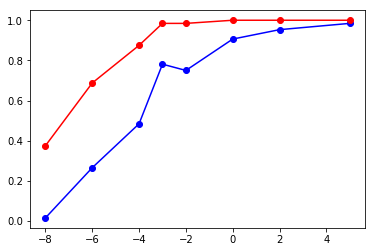

In [25]:
plt.plot(np.load('./data/snrs.npy'), np.load('./data/nn_accs2.npy'), '-bo')
plt.plot(np.load('./data/snrs.npy'), np.load('./data/mle_accs2.npy'), '-ro') 
plt.show()

# testing snr's for N=512, M=32

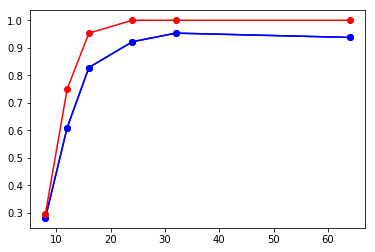

In [21]:
plt.plot(np.load('./data/ms.npy'), np.load('./data/nn_accs.npy'), '-bo')
plt.plot(np.load('./data/ms.npy'), np.load('./data/mle_accs.npy'), '-ro') 
plt.show()

# testing subsampling m's for N=512, snr=0db

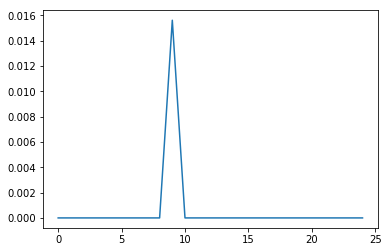

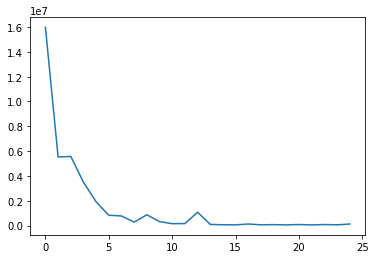

'\n500 iter, N=256,3 hidden layer each w 256 neuron, batchsize=32\nfully sampled: test accuracy ~98%\nm=240: test accuracy ~28%'

In [11]:
plt.plot(accuracies)
plt.show()
plt.plot(losses)
plt.show()

'''
500 iter, N=256,3 hidden layer each w 256 neuron, batchsize=32
fully sampled: test accuracy ~98%
m=240: test accuracy ~28%'''
